In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gdown
import numpy as np
import struct
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

In [3]:
def download_data(file_id, name_file):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, name_file, quiet=False)
    return name_file

def read_labels(file_path):
    class_names = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }
    
    with open(file_path, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        
    df = pd.DataFrame(labels, columns=["label"])
    df["class_name"] = df["label"].map(class_names)
    return df

def extrar_feature_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        print("Número de imágenes:", num_images)
        print("Dimensiones de cada imagen:", rows, "x", cols)
        image_data = np.frombuffer(f.read(), dtype=np.uint8)
        images = image_data.reshape(num_images, rows, cols)
        X = images.reshape(num_images, rows * cols)
        print("Forma de la matriz final:", X.shape)
        
    return X

def Show_Image(X,nro_imagen):
    if nro_imagen < 0 or nro_imagen >= X.shape[0]:
        raise IndexError(f"El índice {nro_imagen} está fuera de rango. Debe estar entre 0 y {X.shape[0]-1}")
    
    img = X[nro_imagen].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f"Imagen #{nro_imagen}")
    plt.axis('off')
    plt.show()

In [4]:
# Descargando la data solo la primera vez
file_train_X = download_data("1enziBIpqiv_t95KQcifsclNH2BdR8lAd","train_X")
file_test_X = download_data("1Jeax6tnQ6Nmr2PTNXdQqzKnN0YqtrLe4","test_X")
file_train_Y = download_data("1MZtn2iA5cgiYT1i3O0ECuR01oD0kGHh7","train_Y")
file_test_Y = download_data("1K5pxwk2s3RDYsYuwv8RftJTXZ-RGR7K4","test_Y")

Downloading...
From: https://drive.google.com/uc?id=1enziBIpqiv_t95KQcifsclNH2BdR8lAd
To: d:\Miguel\OneDrive\Escritorio\UTEC\2025-2\Machine Learning\Proy2\train_X
100%|██████████| 47.0M/47.0M [00:17<00:00, 2.69MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Jeax6tnQ6Nmr2PTNXdQqzKnN0YqtrLe4
To: d:\Miguel\OneDrive\Escritorio\UTEC\2025-2\Machine Learning\Proy2\test_X
100%|██████████| 7.84M/7.84M [00:02<00:00, 2.82MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MZtn2iA5cgiYT1i3O0ECuR01oD0kGHh7
To: d:\Miguel\OneDrive\Escritorio\UTEC\2025-2\Machine Learning\Proy2\train_Y
100%|██████████| 60.0k/60.0k [00:00<00:00, 699kB/s]
Downloading...
From: https://drive.google.com/uc?id=1K5pxwk2s3RDYsYuwv8RftJTXZ-RGR7K4
To: d:\Miguel\OneDrive\Escritorio\UTEC\2025-2\Machine Learning\Proy2\test_Y
100%|██████████| 10.0k/10.0k [00:00<00:00, 442kB/s]


In [5]:
train_X = extrar_feature_images(file_train_X )
test_X = extrar_feature_images(file_test_X )
train_Y = read_labels(file_train_Y)
test_Y = read_labels(file_test_Y)

Número de imágenes: 60000
Dimensiones de cada imagen: 28 x 28
Forma de la matriz final: (60000, 784)
Número de imágenes: 10000
Dimensiones de cada imagen: 28 x 28
Forma de la matriz final: (10000, 784)


In [6]:
print("Data train : ",train_X.shape)
print("Label train : ",train_Y.shape)
print("Data test : ", test_X.shape)
print("Label test : ", test_Y.shape)

Data train :  (60000, 784)
Label train :  (60000, 2)
Data test :  (10000, 784)
Label test :  (10000, 2)


In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler.fit_transform(train_X)
X_test_scaled = scaler.fit_transform(test_X)

y_train = train_Y['label']
y_test = test_Y['label']

In [20]:
def generar_matriz_confusion(
    y_true, y_pred, modelo_nombre, class_names=None, save_path=None
):
    classes = sorted(np.unique(np.concatenate([y_true, y_pred])))
    cm = confusion_matrix(y_true, y_pred, labels=classes, normalize='true')
    fmt = ".2f"

    # Si el diccionario se pasó, mapear correctamente
    if isinstance(class_names, dict):
        labels = [class_names[c] for c in classes]
    else:
        labels = class_names if class_names is not None else classes

    # Crear visualización
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap="Blues", values_format=fmt, colorbar=False)
    plt.title(f"Matriz de Confusión - {modelo_nombre}")
    plt.tight_layout()

    # Guardar imagen
    if save_path is None:
        modelo_safe = modelo_nombre.replace(" ", "_").replace("/", "_")
        save_path = f"confusion_matrix_{modelo_safe}.png"

    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"✓ Matriz de confusión guardada en: {save_path}")

    plt.close(fig)

    return cm

class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# PCA

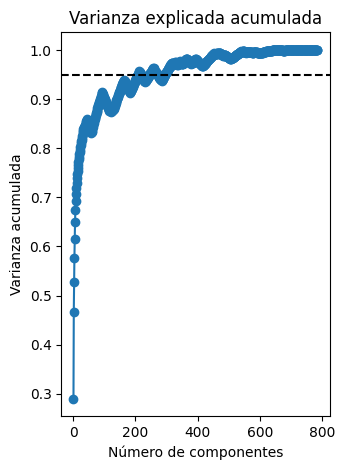

In [9]:
mean = np.mean(X_train_scaled, axis=0)
X_center = X_train_scaled - mean

X_cov = np.round(np.cov(X_center.T), 2)

eig_val, eig_vec = np.linalg.eig(X_cov)

sum_eig_val = np.sum(eig_val)
explained_variance = eig_val/sum_eig_val

cumulative_variance = np.cumsum(explained_variance)

pca_data = np.dot(X_center, eig_vec)

plt.subplot(1,2,2)
plt.plot(np.arange(1, len(eig_val)+1), cumulative_variance, marker='o')
plt.axhline(0.95, color='black', linestyle='--')
plt.title('Varianza explicada acumulada')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.tight_layout()
plt.show()

k = np.searchsorted(cumulative_variance, 0.95) + 1

W_k = eig_vec[:, :k]
X_reduced = X_center.dot(W_k)
X_test_center = X_test_scaled - mean
X_test_reduced = X_test_center.dot(W_k)  

## REGRESIÓN LOGÍSTICA

In [10]:
LogRegression_model_pca = LogisticRegression(max_iter=10000)

LogRegression_model_pca.fit(X_reduced, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [11]:
y_pred_LR_pca = LogRegression_model_pca.predict(X_test_reduced)

In [12]:
print("Accuracy:", accuracy_score(y_test, y_pred_LR_pca))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_LR_pca))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_LR_pca))

Accuracy: 0.8448
Matriz de confusión:
 [[805   5  16  48   5   3 106   0  12   0]
 [  2 957   2  27   5   0   6   0   1   0]
 [ 20   4 736  10 128   1  89   1  11   0]
 [ 26  10  12 874  26   1  44   0   7   0]
 [  0   2 109  39 752   0  91   1   6   0]
 [  0   0   0   1   0 930   0  48   4  17]
 [143   3 123  39 101   0 561   0  30   0]
 [  0   0   0   0   0  33   0 940   0  27]
 [  5   1   6  12   3   4  17   6 946   0]
 [  0   1   0   0   0  14   0  37   1 947]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      0.81      0.80      1000
           1       0.97      0.96      0.97      1000
           2       0.73      0.74      0.73      1000
           3       0.83      0.87      0.85      1000
           4       0.74      0.75      0.74      1000
           5       0.94      0.93      0.94      1000
           6       0.61      0.56      0.59      1000
           7       0.91      0.94      0.92      1000
           8    

AttributeError: 'LogisticRegression' object has no attribute 'replace'

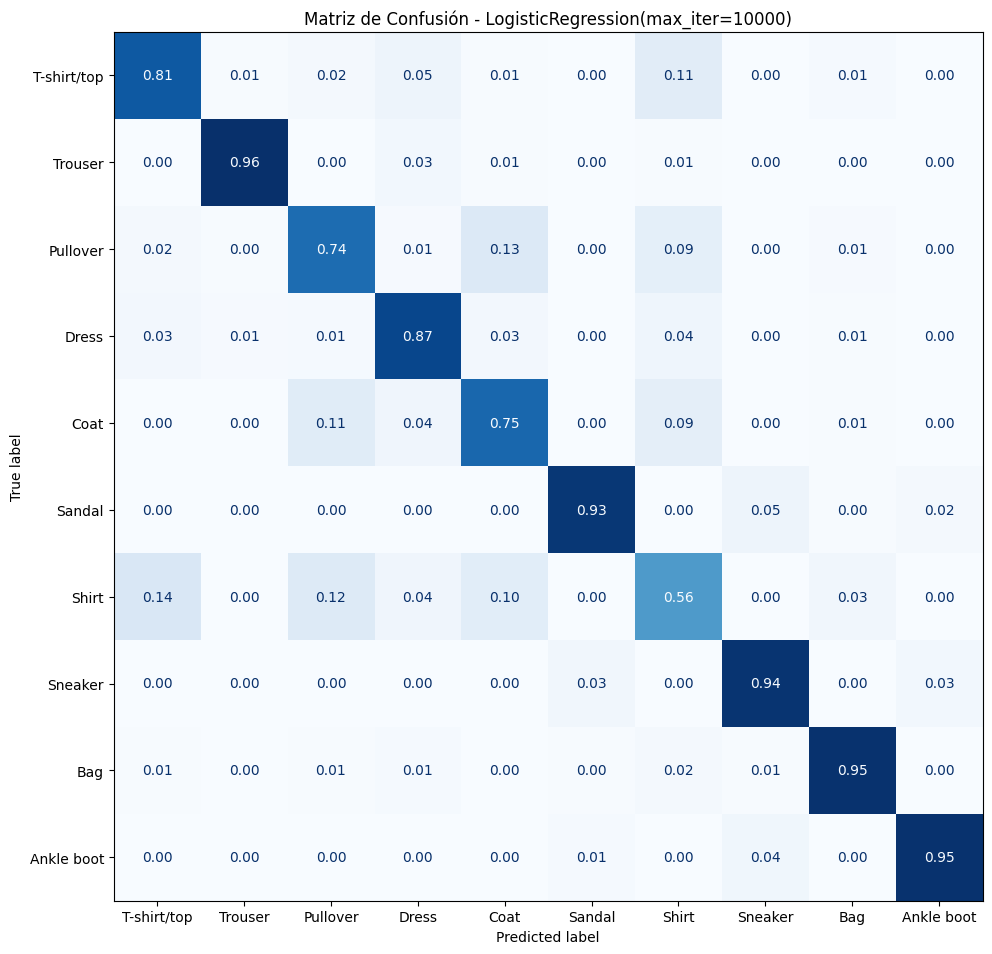

In [21]:
generar_matriz_confusion(y_test, y_pred_LR_pca, LogRegression_model_pca, class_names, save_path=None)

## SVM

In [22]:
SVM_model_pca = SVC(C = 3.5)

SVM_model_pca.fit(X_reduced, y_train)

,C,3.5
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [23]:
y_pred_SVM_pca = SVM_model_pca.predict(X_test_reduced)

In [24]:
print("Accuracy:", accuracy_score(y_test, y_pred_SVM_pca))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_SVM_pca))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_SVM_pca))

Accuracy: 0.8949
Matriz de confusión:
 [[853   0  13  22   5   1 100   0   6   0]
 [  4 971   0  19   2   0   4   0   0   0]
 [ 14   2 829  12  82   0  61   0   0   0]
 [ 21   3  16 906  28   0  23   0   3   0]
 [  1   1  83  23 833   0  58   0   1   0]
 [  0   0   0   1   0 962   0  26   1  10]
 [122   0  82  29  59   0 695   0  13   0]
 [  0   0   0   0   0  13   0 968   0  19]
 [  2   0   3   6   4   3   4   4 974   0]
 [  0   0   0   0   0   7   1  34   0 958]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.83      0.82      1000
           3       0.89      0.91      0.90      1000
           4       0.82      0.83      0.83      1000
           5       0.98      0.96      0.97      1000
           6       0.73      0.69      0.71      1000
           7       0.94      0.97      0.95      1000
           8    

AttributeError: 'SVC' object has no attribute 'replace'

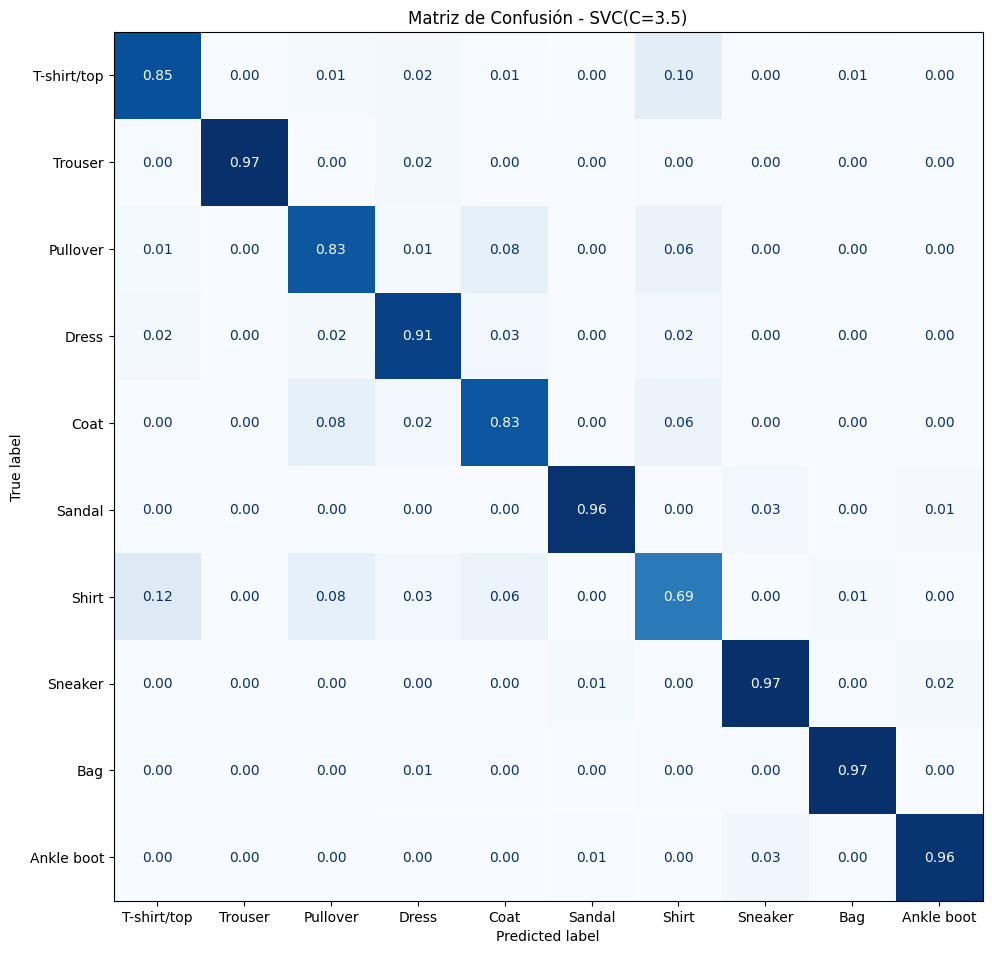

In [26]:
generar_matriz_confusion(y_test, y_pred_SVM_pca, SVM_model_pca, class_names, save_path=None)

## RANDOM FOREST

In [27]:
RF_model_pca = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
RF_model_pca.fit(X_reduced, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [28]:
y_pred_RF_pca = RF_model_pca.predict(X_test_reduced)

In [29]:
print("Accuracy:", accuracy_score(y_test, y_pred_RF_pca))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_RF_pca))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_RF_pca))

Accuracy: 0.8559
Matriz de confusión:
 [[838   0  17  37   8   4  77   0  19   0]
 [  4 954   2  31   3   0   4   0   2   0]
 [ 12   0 801  10 109   1  51   0  16   0]
 [ 32   5  14 880  32   1  30   0   6   0]
 [  0   2 101  33 799   1  56   0   8   0]
 [  0   0   0   2   0 923   0  37   4  34]
 [174   1 125  32  95   3 536   0  34   0]
 [  0   0   0   0   0  31   0 923   1  45]
 [  2   0   3   5   4  18   9   3 954   2]
 [  0   0   0   0   0  19   0  29   1 951]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81      1000
           1       0.99      0.95      0.97      1000
           2       0.75      0.80      0.78      1000
           3       0.85      0.88      0.87      1000
           4       0.76      0.80      0.78      1000
           5       0.92      0.92      0.92      1000
           6       0.70      0.54      0.61      1000
           7       0.93      0.92      0.93      1000
           8    

AttributeError: 'RandomForestClassifier' object has no attribute 'replace'

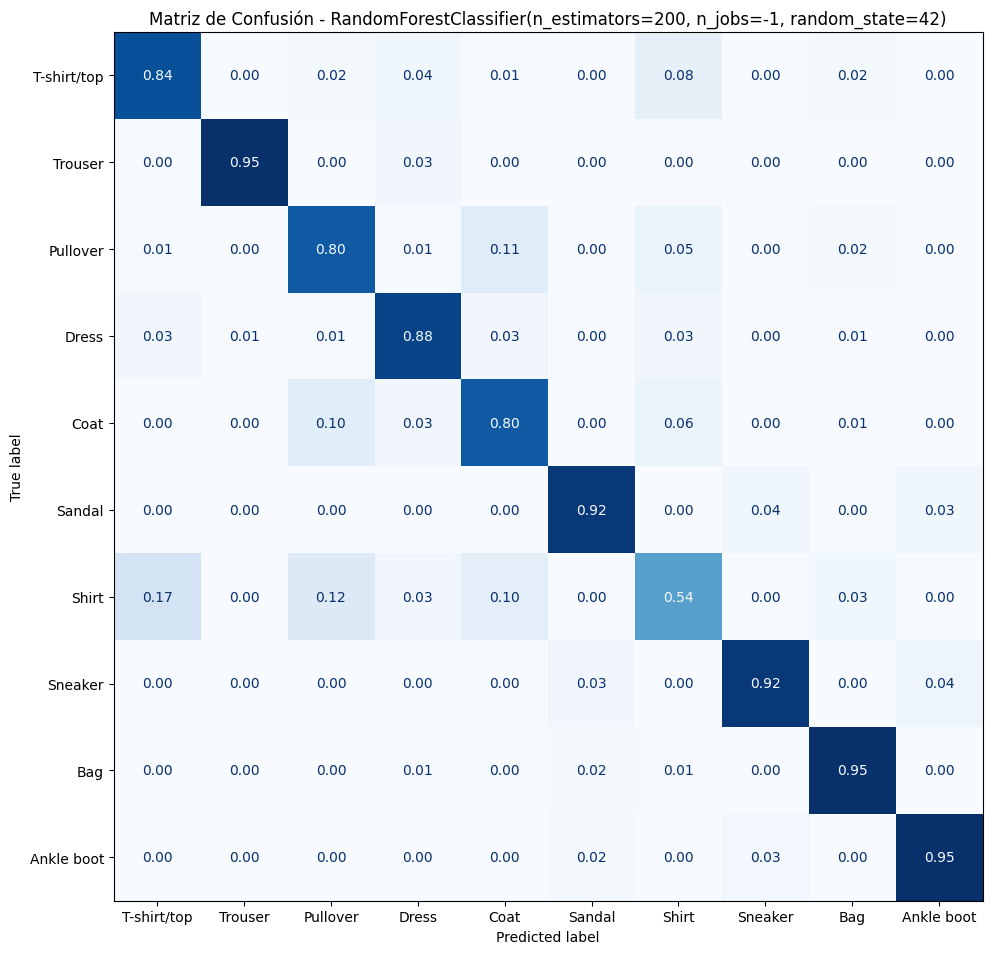

In [30]:
generar_matriz_confusion(y_test, y_pred_RF_pca, RF_model_pca, class_names, save_path=None)

## KNN

In [31]:
KNN_model_pca = KNeighborsClassifier(n_neighbors=10, weights='distance', n_jobs=-1)
KNN_model_pca.fit(X_reduced, y_train)

,n_neighbors,10
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,-1


In [32]:
y_pred_KNN_pca = KNN_model_pca.predict(X_test_reduced)

In [33]:
print("Accuracy:", accuracy_score(y_test, y_pred_KNN_pca))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_KNN_pca))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_KNN_pca))

Accuracy: 0.8587
Matriz de confusión:
 [[841   0  17  17   6   1 107   1  10   0]
 [  6 965   5  15   5   0   3   0   1   0]
 [ 13   2 793   8  99   0  82   0   3   0]
 [ 31   5  12 873  43   0  34   0   2   0]
 [  1   0  95  23 781   0  96   0   4   0]
 [  1   0   0   1   0 839   0  89   1  69]
 [160   0 112  22  80   0 612   0  14   0]
 [  0   0   0   0   0   3   0 957   0  40]
 [  1   0   8   5   5   0  11   6 962   2]
 [  0   0   0   0   0   1   0  34   1 964]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.76      0.79      0.78      1000
           3       0.91      0.87      0.89      1000
           4       0.77      0.78      0.77      1000
           5       0.99      0.84      0.91      1000
           6       0.65      0.61      0.63      1000
           7       0.88      0.96      0.92      1000
           8    

AttributeError: 'KNeighborsClassifier' object has no attribute 'replace'

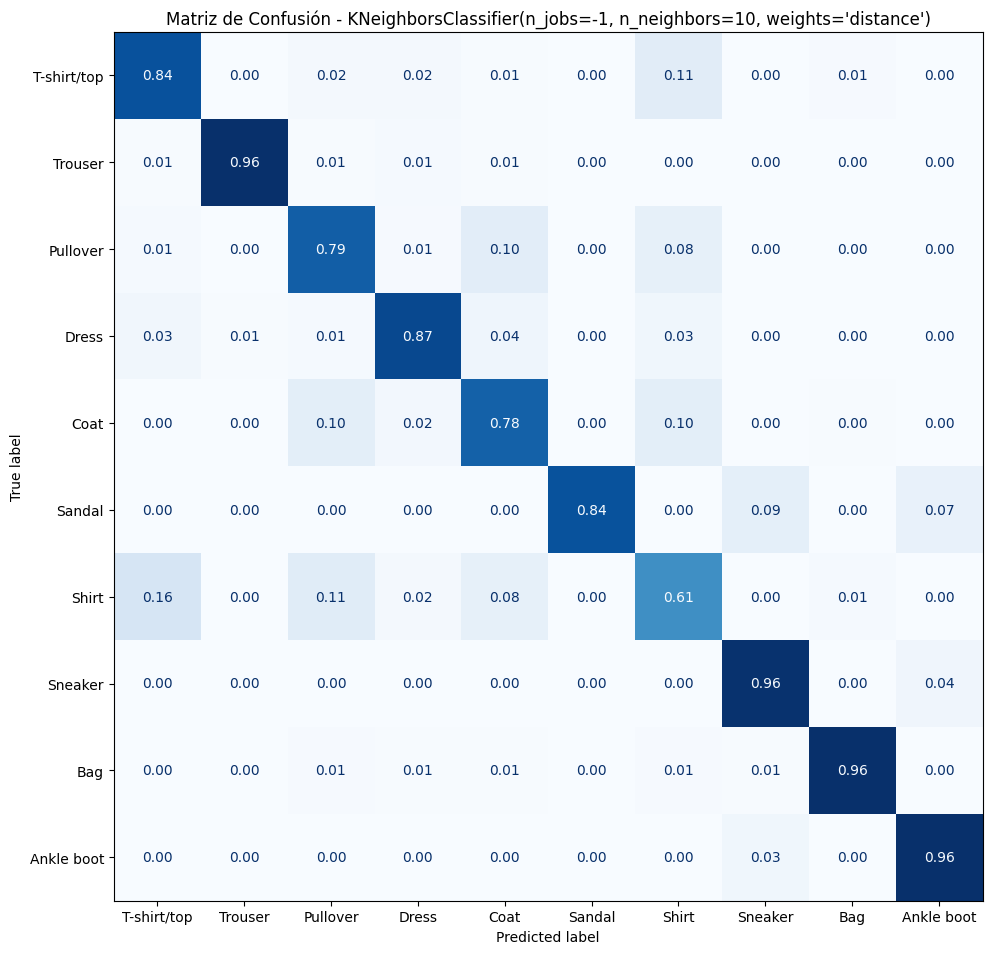

In [34]:
generar_matriz_confusion(y_test, y_pred_KNN_pca, KNN_model_pca, class_names, save_path=None)

# NMF

In [35]:
def random_init(M, rank):
    num_samples = M.shape[0]
    num_features = M.shape[1]
    W = np.random.uniform(1, 2, (num_samples, rank))
    H = np.random.uniform(1, 2, (rank, num_features))
    return W, H

def update(X, W, H):
    epsilon = 1.0e-10

    numerator_H = W.T.dot(X)
    denominator_H = W.T.dot(W).dot(H) + epsilon
    H = H * (numerator_H/denominator_H)

    numerator_W = X.dot(H.T)
    denominator_W = W.dot(H).dot(H.T) + epsilon
    W = W*(numerator_W/denominator_W)

    return W, H

def loss(X, W, H):
    X_app = W.dot(H)
    return np.linalg.norm(X-X_app)

def train(X, rank, iter):
    W, H = random_init(X, rank)

    l_list = []
    for i in range(iter):
        W, H = update(X, W, H)
        l = loss(X, W, H)
        l_list.append(l)

    return W, H, l_list

In [36]:
W, H, l_list = train(X_train_scaled, 15,120)

In [37]:
H_pinv = np.linalg.pinv(H)
W_test = X_test_scaled.dot(H_pinv)
W_test = np.clip(W_test, 0, None)

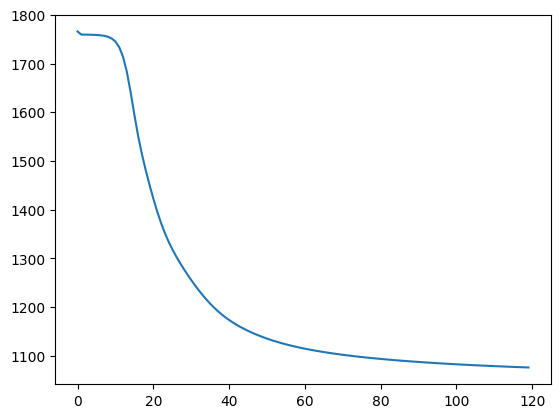

In [38]:
plt.plot(l_list)

## REGRESION LOGISTICA

In [39]:
LogRegression_model_nmf = LogisticRegression(max_iter=10000)

LogRegression_model_nmf.fit(W, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [40]:
y_pred_LR_nmf = LogRegression_model_nmf.predict(W_test)

In [41]:
print("Accuracy:", accuracy_score(y_test, y_pred_LR_nmf))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_LR_nmf))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_LR_nmf))

Accuracy: 0.7541
Matriz de confusión:
 [[731   6  10  89   8   4 130   0  22   0]
 [  2 919  12  56   6   0   4   0   1   0]
 [  9   5 590  10 187   1 179   0  19   0]
 [ 32  15   5 802  51   0  88   0   7   0]
 [  0   3 157  34 664   0 131   0  11   0]
 [  0   1   0   1   0 855   0  47  24  72]
 [151   6 143  59 154   0 449   0  38   0]
 [  0   0   0   0   0 180   0 678   5 137]
 [  0   2  16   6   9   3  26   2 935   1]
 [  0   0   1   0   0  46   0  32   3 918]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76      1000
           1       0.96      0.92      0.94      1000
           2       0.63      0.59      0.61      1000
           3       0.76      0.80      0.78      1000
           4       0.62      0.66      0.64      1000
           5       0.79      0.85      0.82      1000
           6       0.45      0.45      0.45      1000
           7       0.89      0.68      0.77      1000
           8    

AttributeError: 'LogisticRegression' object has no attribute 'replace'

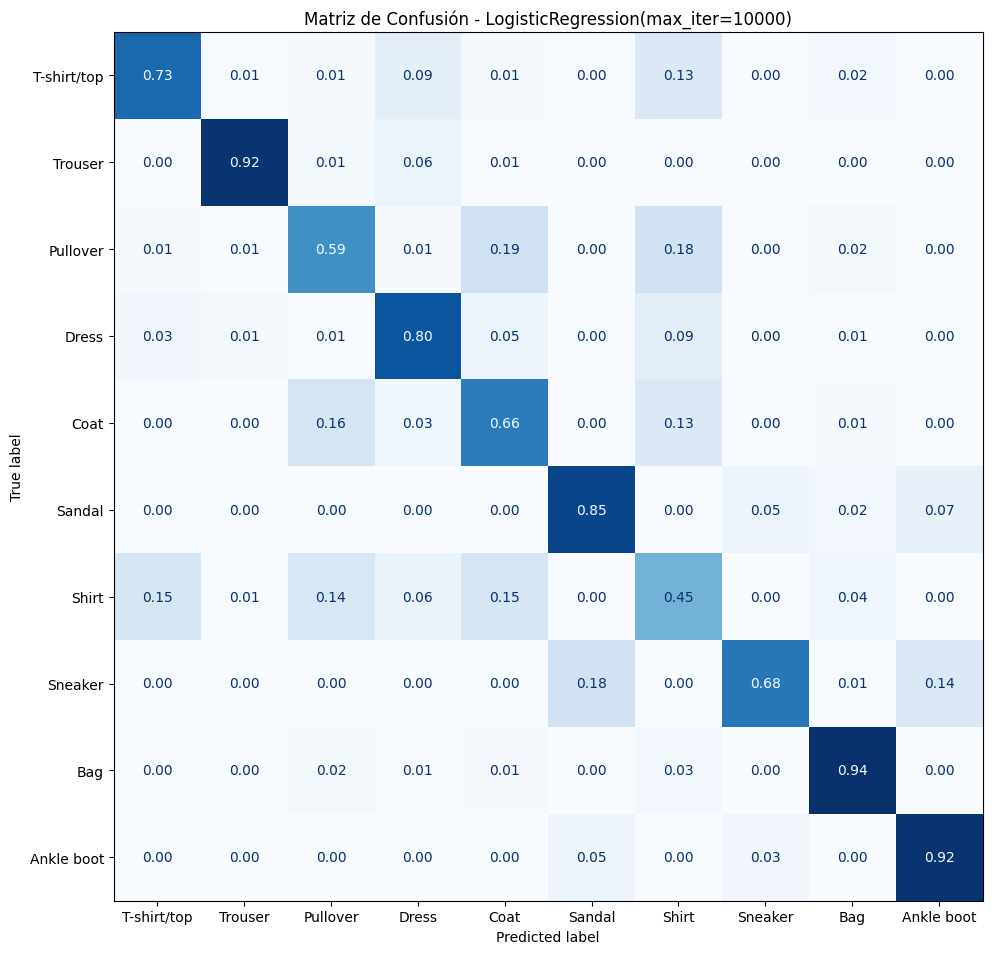

In [43]:
generar_matriz_confusion(y_test, y_pred_LR_nmf, LogRegression_model_nmf, class_names, save_path=None)

## SVM

In [44]:
SVM_model_nmf = SVC(C = 1)

SVM_model_nmf.fit(W, y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [45]:
y_pred_SVM_nmf = SVM_model_nmf.predict(W_test)

In [46]:
print("Accuracy:", accuracy_score(y_test, y_pred_SVM_nmf))  
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_SVM_nmf))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_SVM_nmf))

Accuracy: 0.814
Matriz de confusión:
 [[770   2  14  68   8   1 123   0  14   0]
 [  4 924   6  53   7   0   5   0   1   0]
 [ 13   1 710  17  92   1 158   0   8   0]
 [ 19   6   5 872  48   0  45   0   5   0]
 [  0   2 155  42 680   0 117   0   4   0]
 [  1   0   0   2   0 869   0  63  12  53]
 [137   3 120  40  79   0 603   0  18   0]
 [  0   0   0   0   0  93   0 807   3  97]
 [  2   1   4   7   6   5  11   1 962   1]
 [  0   0   0   0   0  25   0  31   1 943]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      1000
           1       0.98      0.92      0.95      1000
           2       0.70      0.71      0.71      1000
           3       0.79      0.87      0.83      1000
           4       0.74      0.68      0.71      1000
           5       0.87      0.87      0.87      1000
           6       0.57      0.60      0.58      1000
           7       0.89      0.81      0.85      1000
           8     

AttributeError: 'SVC' object has no attribute 'replace'

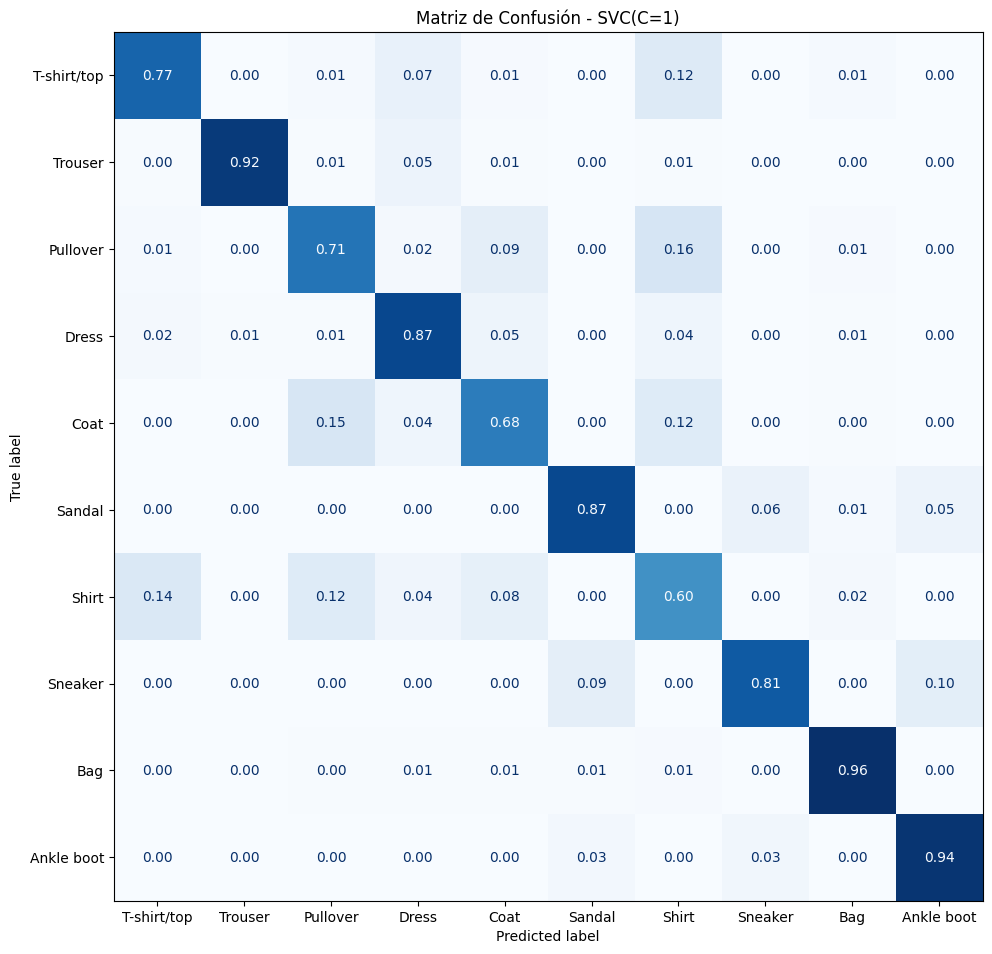

In [47]:
generar_matriz_confusion(y_test, y_pred_SVM_nmf, SVM_model_nmf, class_names, save_path=None)

## RANDOM FOREST

In [48]:
RF_model_nmf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
RF_model_nmf.fit(W, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [49]:
y_pred_RF_nmf = RF_model_nmf.predict(W_test)

In [50]:
print("Accuracy:", accuracy_score(y_test, y_pred_RF_nmf))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_RF_nmf))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_RF_nmf))

Accuracy: 0.7355
Matriz de confusión:
 [[785   2  24  81   5   4  85   0  14   0]
 [  3 895   6  88   5   0   1   0   2   0]
 [ 13   0 782  13 106   1  79   0   6   0]
 [ 23   4  18 871  43   3  32   0   6   0]
 [  0   2 252  46 647   1  48   0   4   0]
 [  0   0   0   0   0 976   0   6  10   8]
 [170   3 189  62 116   3 436   0  21   0]
 [  0   0   0   0   0 588   0 381   5  26]
 [  0   0  13   5   9  10   9   1 952   1]
 [  0   0   0   0   0 324   0  45   1 630]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79      1000
           1       0.99      0.90      0.94      1000
           2       0.61      0.78      0.68      1000
           3       0.75      0.87      0.80      1000
           4       0.69      0.65      0.67      1000
           5       0.51      0.98      0.67      1000
           6       0.63      0.44      0.52      1000
           7       0.88      0.38      0.53      1000
           8    

AttributeError: 'RandomForestClassifier' object has no attribute 'replace'

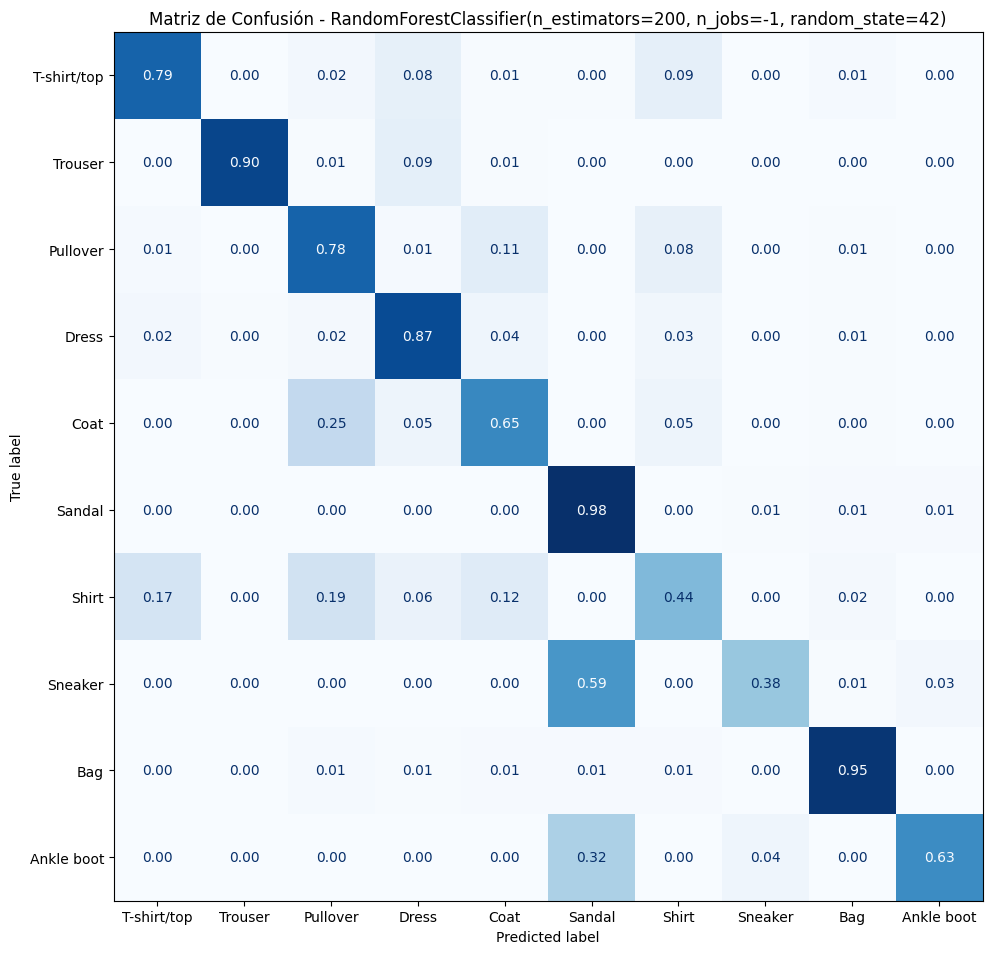

In [51]:
generar_matriz_confusion(y_test, y_pred_RF_nmf, RF_model_nmf, class_names, save_path=None)

## KNN

In [52]:
KNN_model_nmf = KNeighborsClassifier(n_neighbors=10, weights='distance', n_jobs=-1)
KNN_model_nmf.fit(W, y_train)

,n_neighbors,10
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,-1


In [53]:
y_pred_KNN_nmf = KNN_model_nmf.predict(W_test)

In [54]:
print("Accuracy:", accuracy_score(y_test, y_pred_KNN_nmf))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_KNN_nmf))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_KNN_nmf))

Accuracy: 0.8098
Matriz de confusión:
 [[780   4  18  38  11   3 134   0  11   1]
 [  6 945   5  34   4   0   4   0   2   0]
 [ 14   3 718  12 102   1 141   0   9   0]
 [ 28  13  14 840  64   0  37   0   4   0]
 [  0   1 160  32 686   0 116   0   4   1]
 [  2   0   0   0   0 782   0 135   4  77]
 [126   3 128  35  89   1 596   0  22   0]
 [  0   0   0   0   0  57   0 846   1  96]
 [  1   0   5   8   6  11  13   3 951   2]
 [  0   0   0   0   0  11   0  34   1 954]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      1000
           1       0.98      0.94      0.96      1000
           2       0.69      0.72      0.70      1000
           3       0.84      0.84      0.84      1000
           4       0.71      0.69      0.70      1000
           5       0.90      0.78      0.84      1000
           6       0.57      0.60      0.58      1000
           7       0.83      0.85      0.84      1000
           8    

AttributeError: 'KNeighborsClassifier' object has no attribute 'replace'

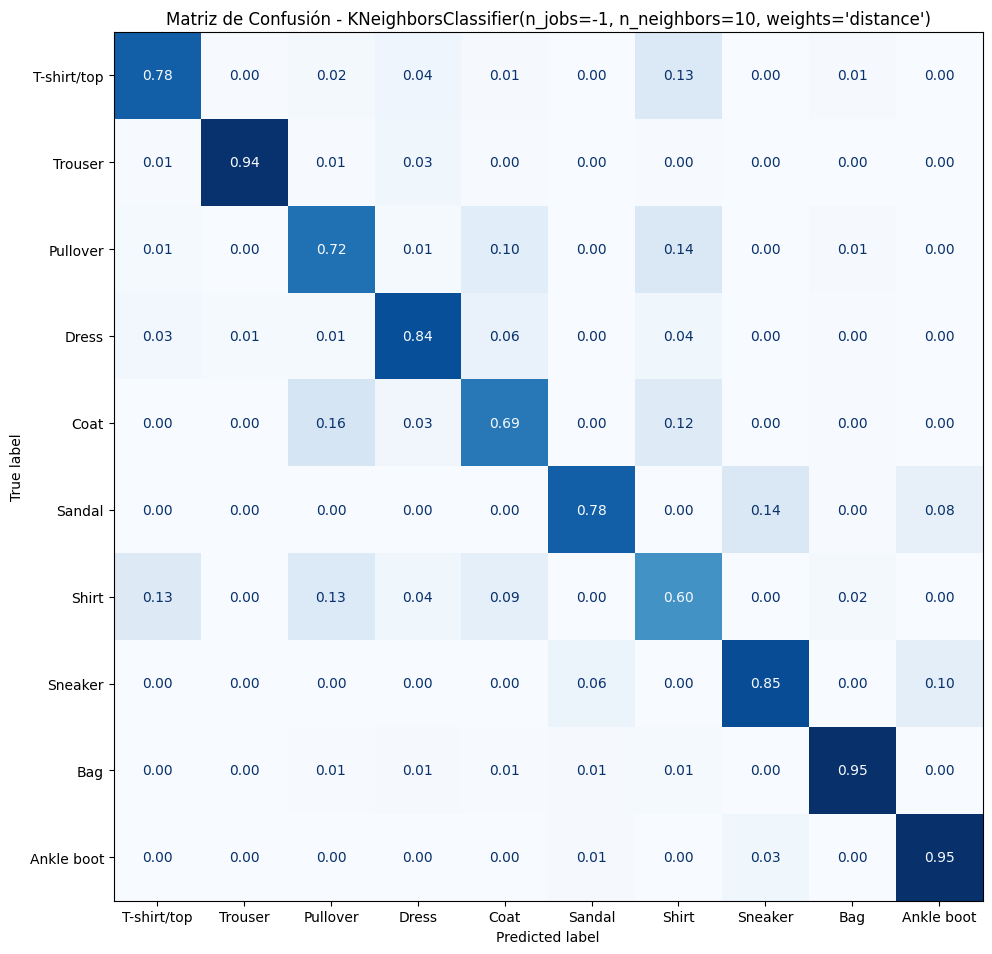

In [55]:
generar_matriz_confusion(y_test, y_pred_KNN_nmf, KNN_model_nmf, class_names, save_path=None)